In [180]:
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import random
import numpy as np
from matplotlib import ticker
import matplotlib.pyplot as plt
from scipy.special import betainc, hyp2f1, gamma
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
font = {'size': 30, 'weight':'normal'}
plt.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "text.latex.preamble": r"\usepackage{amssymb}",
})
rng = np.random.default_rng(seed=42)
colors = [['blue',"slateblue"], ['darkgoldenrod', "goldenrod"], ['red', "indianred",], ['olivedrab', "yellowgreen"], ['plum',"pink"], ['black','dimgray'], ['orangered','coral'] ]

locminx = ticker.LogLocator(base=10.0,subs=np.linspace(0,1,11),numticks=12)
locmajx = ticker.LogLocator(base=10,numticks=12) 
locminy = ticker.LogLocator(base=10.0,subs=np.linspace(0,1,11),numticks=12)
locmajy = ticker.LogLocator(base=10,numticks=12) 
from collections import Counter
import bisect

def finv(x,a):
    return a/x

import numpy as np
import random, bisect

class MemoryWalk:
    def __init__(self, T, q, beta, tau=1.0):
        self.T = T
        self.q = q
        self.beta = beta
        self.tau = tau

        # Precompute unnormalized cumulative weights for lags 1..T
        lags = np.arange(0, T+1)
        weights = 1.0 / ((lags + tau) ** beta)
        self.cumW = np.cumsum(weights)  # no normalization here

    def sample_lag_up_to_t(self, t):
        """
        Sample lag ℓ in {1,..,t} with prob ∝ (ℓ+τ)^(-β).
        Uses precomputed cumulative weights, truncated at t.
        """
        total = self.cumW[t-1]             # total weight up to lag=t
        r = random.random() * total
        idx = bisect.bisect_left(self.cumW, r, 0, t)
        return idx+1                     # lag in 1..t

    def simulate_with_flips(self):
        positions = [0]
        L, R = 0, 0
        expansions = []  # "L" or "R"

        for t in range(1, self.T + 1):
            if random.random() < self.q:
                if t == 0:
                    newpos = positions[0]
                else:
                    lag = self.sample_lag_up_to_t(t)
                    newpos = positions[t - lag]
            else:
                step = 1 if random.random() < 0.5 else -1
                newpos = positions[-1] + step

            positions.append(newpos)

            # Check for new boundary
            if newpos < L:
                L = newpos
                expansions.append("L")
            elif newpos > R:
                R = newpos
                expansions.append("R")

        return expansions


def estimate_flip_probabilities(T, q, beta, tau=1.0, ntrials=1000):
    """
    Estimate pi_n = probability of a flip at n-th expansion (new site visited).
    Returns:
        ns   : numpy array of expansion indices
        pi   : estimated flip probabilities
        err  : standard errors for each pi_n
    """
    flip_counts = {}
    total_counts = {}
    max_n = 0

    walker = MemoryWalk(T, q, beta, tau)

    for _ in range(ntrials):
        expansions = walker.simulate_with_flips()
        max_n = max(max_n, len(expansions))
        for n in range(1, len(expansions)):
            prev_side = expansions[n-1]
            curr_side = expansions[n]
            total_counts[n] = total_counts.get(n, 0) + 1
            if prev_side != curr_side:
                flip_counts[n] = flip_counts.get(n, 0) + 1

    ns, pi, err = [], [], []
    for n in sorted(total_counts.keys()):
        N = total_counts[n]
        k = flip_counts.get(n, 0)
        p_hat = k / N
        sigma = np.sqrt(p_hat * (1 - p_hat) / N)
        ns.append(n)
        pi.append(p_hat)
        err.append(sigma)

    return np.array(ns), np.array(pi), np.array(err)



In [194]:
if __name__ == "__main__":
    T = 100000
    q = 0.1
    beta = 2
    tau = 1.0

    n,pi,err = estimate_flip_probabilities(T, q, beta, tau, ntrials=5000)
np.save(f"./Simus/n-q{q}-T{T}-beta{beta}.npy",n)
np.save(f"./Simus/pi-q{q}-T{T}-beta{beta}.npy",pi)
np.save(f"./Simus/err-q{q}-T{T}-beta{beta}.npy",err)

635
[1.23930578] [[0.00018553]]


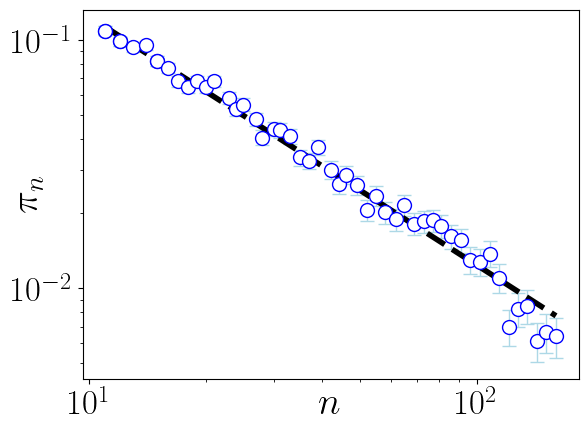

In [205]:
fig, ax = plt.subplots(1, 1)
q=0.3
beta=2.1
plt.semilogx()
plt.semilogy()
plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25)
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='center')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

T=100000
n=np.load(f"./Simus/n-q{q}-T{T}-beta{beta}.npy")
pi=np.load(f"./Simus/pi-q{q}-T{T}-beta{beta}.npy")
err=np.load(f"./Simus/err-q{q}-T{T}-beta{beta}.npy")

Ind=np.int64(np.logspace(1,np.log10(np.max(n))-.6,50))
print(n[-1])

plt.errorbar(n[Ind],pi[Ind],yerr=err[Ind], fmt='o', color='blue', ecolor='lightblue', elinewidth=1, capsize=5, markersize=10, markerfacecolor='white', markeredgewidth=1)
A,var = curve_fit(finv, n[Ind], pi[Ind], sigma=err[Ind])
print(A,var)
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)

# T=100000
# n=np.load(f"./Simus/n-q{q}-T{T}-beta{beta}.npy")
# pi=np.load(f"./Simus/pi-q{q}-T{T}-beta{beta}.npy")
# err=np.load(f"./Simus/err-q{q}-T{T}-beta{beta}.npy")

# Ind=np.int64(np.logspace(1,np.log10(np.max(n))-.5,40))

# plt.errorbar(n[Ind],pi[Ind],yerr=err[Ind], fmt='o', color='blue', ecolor='lightblue', elinewidth=1, capsize=5, markersize=10, markerfacecolor='white', markeredgewidth=1)
# A,var = curve_fit(finv, n[Ind], pi[Ind], sigma=err[Ind])
# print(A,var)
# plt.plot(n[Ind],A/n[Ind],'--',linewidth=4,color='blue')

# T=1000000
# n=np.load(f"./Simus/n-q{q}-T{T}-beta{beta}.npy")
# pi=np.load(f"./Simus/pi-q{q}-T{T}-beta{beta}.npy")
# err=np.load(f"./Simus/err-q{q}-T{T}-beta{beta}.npy")
# Ind=np.int64(np.logspace(1,np.log10(np.max(n))-.5,40))

# plt.errorbar(n[Ind],pi[Ind],yerr=err[Ind], fmt='o', color='red', ecolor='lightblue', elinewidth=1, capsize=5, markersize=10, markerfacecolor='white', markeredgewidth=1)
# A,var = curve_fit(finv, n[Ind], pi[Ind], sigma=err[Ind])
# print(A,var)
# plt.plot(n[Ind],A/n[Ind],'--',linewidth=4,color='red')

plt.savefig(f'C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Monkey-beta{beta}-q{q}.pdf', dpi=600, bbox_inches='tight')

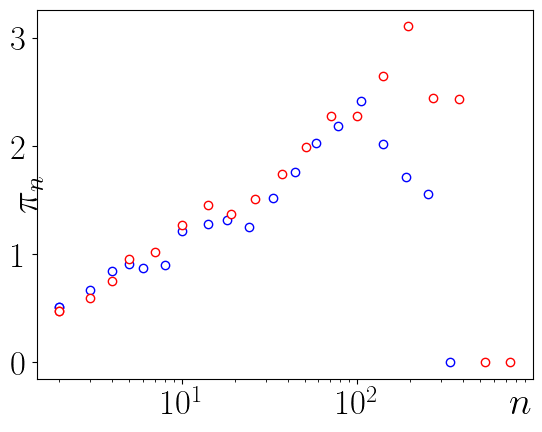

In [254]:
fig, ax = plt.subplots(1, 1)

plt.semilogx()
# plt.semilogy()
plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25)
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

T=100000
n=np.load(f"./Simus/n-q{q}-T{T}-beta{beta}.npy")
pi=np.load(f"./Simus/pi-q{q}-T{T}-beta{beta}.npy")
err=np.load(f"./Simus/err-q{q}-T{T}-beta{beta}.npy")

Ind=np.int64(np.logspace(.1,np.log10(np.max(n))-.1,20))

plt.scatter(n[Ind],pi[Ind]*n[Ind], marker='o', color='blue', facecolor='white')

T=1000000
n=np.load(f"./Simus/n-q{q}-T{T}-beta{beta}.npy")
pi=np.load(f"./Simus/pi-q{q}-T{T}-beta{beta}.npy")
err=np.load(f"./Simus/err-q{q}-T{T}-beta{beta}.npy")
Ind=np.int64(np.logspace(.1,np.log10(np.max(n))-.1,20))

plt.scatter(n[Ind],pi[Ind]*n[Ind],marker='o', color='red', facecolor='white')
# plt.savefig(f'C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Monkey-beta{beta}-q{q}.pdf', dpi=600, bbox_inches='tight')

In [117]:
if __name__ == "__main__":
    T = 500000
    q = 0.01
    beta = 1.3
    tau = 1.0

    n,pi,err = estimate_flip_probabilities(T, q, beta, tau, ntrials=2000)


[ 10  10  11  12  13  15  16  17  19  21  22  24  26  29  31  34  37  40
  44  47  52  56  61  66  72  78  85  92 100 109 118 129 140 152 165 179
 195 212 230 250]
[1.26498982] [[0.00477983]]


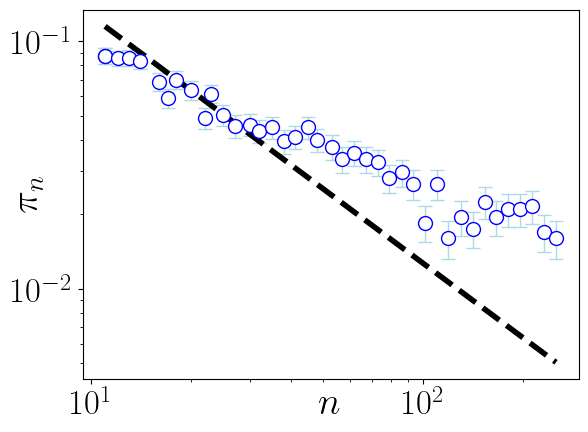

In [118]:
Ind=np.int64(np.logspace(1,np.log10(np.max(n))-.5,40))
print(Ind)

fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],pi[Ind],yerr=err[Ind], fmt='o', color='blue', ecolor='lightblue', elinewidth=1, capsize=5, markersize=10, markerfacecolor='white', markeredgewidth=1)
alpha=1
A,var = curve_fit(finv, n[Ind]**(alpha), pi[Ind], sigma=err[Ind])
print(A,var)
plt.plot(n[Ind],A/n[Ind]**alpha,'--k',linewidth=4)

plt.semilogx()
plt.semilogy()
plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25)
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='center')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig(f'C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Monkey-beta{beta}-q{q}.pdf', dpi=600, bbox_inches='tight')

In [ ]:
if __name__ == "__main__":
    T = 100000
    q = 0.5
    beta = 0.9
    tau = 1.0

    n,pi,err = estimate_flip_probabilities(T, q, beta, tau, ntrials=2000)


[ 5  6  6  6  7  8  8  9 10 10 11 12 13 14 15 16 17 19 20 22 23 25 27 29
 31 34 36 39 42 45 49 52 56 60 65 70 75 81 87 93]
[1.75727228] [[0.00079688]]


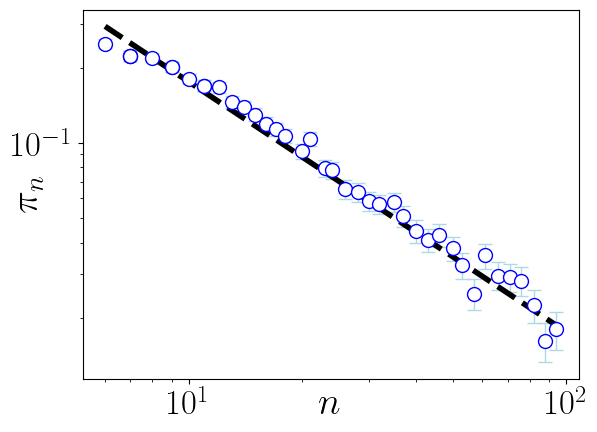

In [86]:
Ind=np.int64(np.logspace(.75,np.log10(np.max(n))-.5,40))
print(Ind)

fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],pi[Ind],yerr=err[Ind], fmt='o', color='blue', ecolor='lightblue', elinewidth=1, capsize=5, markersize=10, markerfacecolor='white', markeredgewidth=1)
A,var = curve_fit(finv, n[Ind], pi[Ind], sigma=err[Ind])
print(A,var)
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)

plt.semilogx()
plt.semilogy()
plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25)
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='center')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig(f'C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Monkey-beta{beta}-q{q}.pdf', dpi=600, bbox_inches='tight')

# Flip prob conditionned on never flip

In [286]:
lags = np.arange(1, 20 + 1, dtype=np.float64)
w = (lags + float(tau)) ** (-float(beta))
np.cumsum(w)

array([ 0.8122524 ,  1.53147549,  2.19122945,  2.80826331,  3.39245399,
        3.95024381,  4.48613055,  5.0034124 ,  5.50459964,  5.99165933,
        6.46616961,  6.92942129,  7.38248741,  7.82627241,  8.26154769,
        8.68897801,  9.10914144,  9.52254472,  9.92963525, 10.33081058])

In [ ]:
# Diagnostic: fraction of runs that reach each expansion index n
# + unconditional flip probability pi_n
# + conditional (no-previous-flip) flip probability p_n
# Uses the corrected lag sampling (no clamping).

import numpy as np
import random, bisect
import matplotlib.pyplot as plt

# ---------- Memory walk with correct lag sampling ----------
class MemoryWalk:
    def __init__(self, q, beta, tau=1.0, max_steps=200000):
        self.q = q
        self.beta = beta
        self.tau = tau
        self.max_steps = max_steps
        # Precompute cumulative weights for lags 1..max_steps (unnormalized)
        lags = np.arange(1, max_steps + 1, dtype=np.float64)
        w = (lags + float(tau)) ** (-float(beta))
        self.cumW = np.cumsum(w)

    def _sample_lag_up_to_t(self, t):
        # sample lag ℓ ∈ {1..t} with prob ∝ (ℓ+τ)^(-β)
        total = self.cumW[t-1]
        r = random.random() * total
        idx = bisect.bisect_left(self.cumW, r)  # search only up to t
        return 1+idx  # lag in 1..t

    def simulate_expansions(self, T):
        """
        Run for T discrete steps; return the sequence of boundary expansions:
        list of 'L'/'R' whenever the visited interval grows by 1 on left/right.
        """
        positions = [0]
        L = R = 0
        expansions = []

        for t in range(1, T + 1):
            if random.random() < self.q:
                if t == 0:
                    newpos = positions[0]
                else:
                    lag = self._sample_lag_up_to_t(t)
                    newpos = positions[t - lag]
            else:
                step = 1 if random.random() < 0.5 else -1
                newpos = positions[-1] + step

            positions.append(newpos)

            if newpos < L:
                L = newpos
                expansions.append('L')
            elif newpos > R:
                R = newpos
                expansions.append('R')

        return expansions

# ---------- Experiment & estimators ----------
def run_experiment(
    T=200000, ntrials=2000, q=0.1, beta=1.5, tau=1.0, max_steps=200000, seed=0
):
    random.seed(seed)
    np.random.seed(seed)

    walker = MemoryWalk(q=q, beta=beta, tau=tau, max_steps=max_steps)

    # Counters
    reach_counts = {}          # how many runs reached expansion index n
    flip_counts_uncond = {}    # flips at n (unconditional)
    total_counts_uncond = {}
    flip_counts_cond0 = {}     # flips at n, conditioned on no previous flip
    total_counts_cond0 = {}

    for _ in range(ntrials):
        exps = walker.simulate_expansions(T)
        m = len(exps)

        # fraction that reached n
        for n in range(1, m + 1):
            reach_counts[n] = reach_counts.get(n, 0) + 1

        # unconditional flip stats
        for n in range(2, m + 1):
            total_counts_uncond[n] = total_counts_uncond.get(n, 0) + 1
            if exps[n - 1] != exps[n - 2]:
                flip_counts_uncond[n] = flip_counts_uncond.get(n, 0) + 1

        # conditional (no-previous-flip) stats
        never_flipped = True
        for n in range(2, m + 1):
            if never_flipped:
                total_counts_cond0[n] = total_counts_cond0.get(n, 0) + 1
                if exps[n - 1] != exps[n - 2]:
                    flip_counts_cond0[n] = flip_counts_cond0.get(n, 0) + 1
                    never_flipped = False  # from now on, not in the conditioned ensemble
            # once you have the first flip, stop contributing to cond0 for larger n
            else:
                break

    return reach_counts, (flip_counts_uncond, total_counts_uncond), (flip_counts_cond0, total_counts_cond0)

def to_arrays(counts_dict):
    ns = np.array(sorted(counts_dict.keys()), dtype=int)
    vals = np.array([counts_dict[n] for n in ns], dtype=float)
    return ns, vals

def build_prob_arrays(flip_counts, total_counts, min_count=50):
    ns = sorted(total_counts.keys())
    ns = [n for n in ns if total_counts[n] >= min_count]
    p = np.array([flip_counts.get(n, 0) / total_counts[n] for n in ns])
    err = np.array([np.sqrt(p[i] * (1 - p[i]) / total_counts[ns[i]]) for i in range(len(ns))])
    return np.array(ns), p, err

# ---------- Run & Plot ----------
if __name__ == "__main__":
    # Parameters (tune as needed)
    T = 50000
    ntrials = 50000
    q = 0.1
    beta = 1.4
    tau = 1.0
    max_steps = T  # safe upper bound for lag table

    reach_counts, uncond, cond0 = run_experiment(T, ntrials, q, beta, tau, max_steps)

    # 1) Fraction of runs that reach each n
    ns_reach, reached = to_arrays(reach_counts)
    frac_reached = reached / ntrials


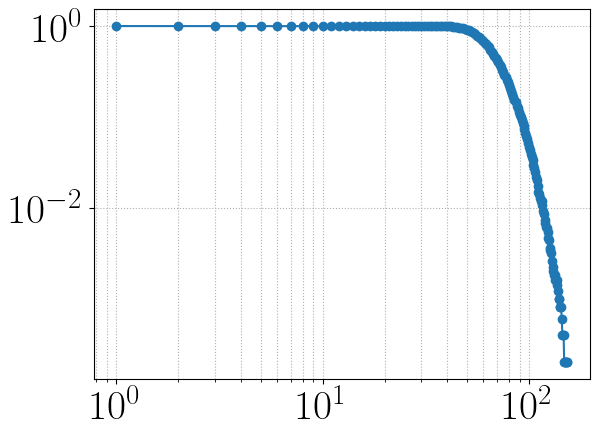

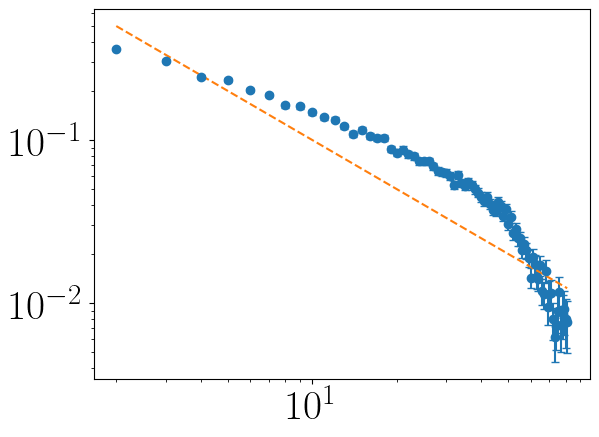

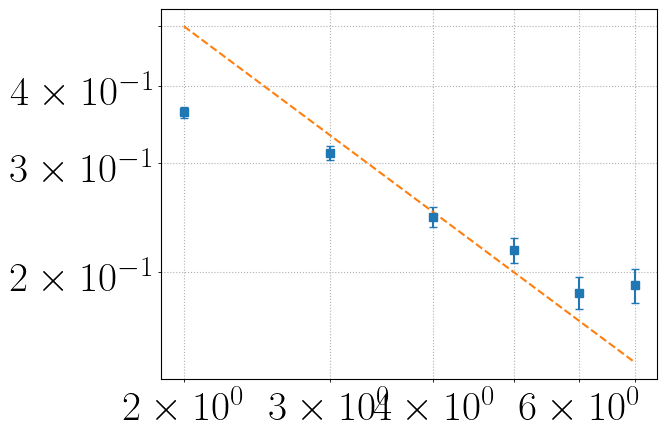

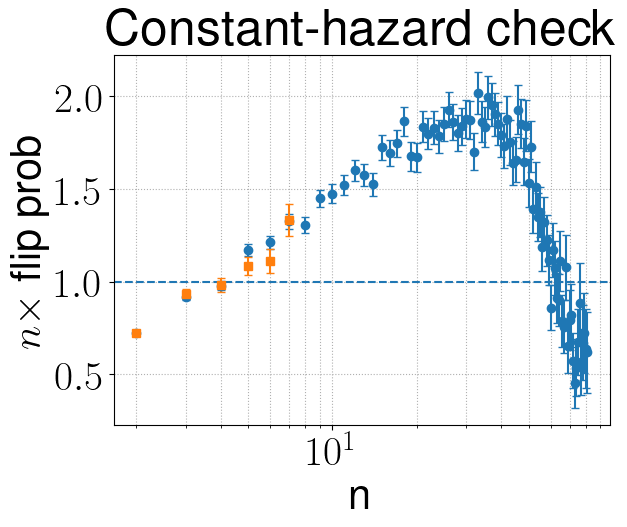

In [380]:
plt.figure()
plt.loglog(ns_reach, frac_reached, 'o-', label='fraction reaching n')
plt.grid(True, which='both', ls=':')
# plt.legend()
plt.show()

# 2) Unconditional pi_n with error bars
ns_u, pi_u, err_u = build_prob_arrays(*uncond, min_count=1000)
plt.figure()
plt.errorbar(ns_u, pi_u, yerr=err_u, fmt='o', capsize=3, label=r'$\pi_n$ (uncond)')
plt.loglog(ns_u, 1/np.array(ns_u), '--', label=r'$1/n$ (guide)')
# plt.legend()
plt.show()

# 3) Conditional (no-previous-flip) p_n with error bars
ns_c, pi_c, err_c = build_prob_arrays(*cond0, min_count=1000)
plt.figure()
plt.errorbar(ns_c, pi_c, yerr=err_c, fmt='s', capsize=3, label=r'$p_n$ (cond: no previous flip)')
plt.loglog(ns_c, 1/np.array(ns_c), '--', label=r'$1/n$ (guide)')
plt.grid(True, which='both', ls=':')
# plt.legend()
plt.show()

# 4) Optional: n * pi_n to check approach to constant
plt.figure()
plt.errorbar(ns_u, ns_u*pi_u, yerr=ns_u*err_u, fmt='o', capsize=3, label=r'$n\,\pi_n$ (uncond)')
if len(ns_c):
    plt.errorbar(ns_c, ns_c*pi_c, yerr=ns_c*err_c, fmt='s', capsize=3, label=r'$n\,p_n$ (cond0)')
plt.axhline(1.0, ls='--', label='1 (guide)')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel(r'$n\times$ flip prob')
plt.title('Constant-hazard check')
plt.grid(True, which='both', ls=':')
# plt.legend()

plt.show()

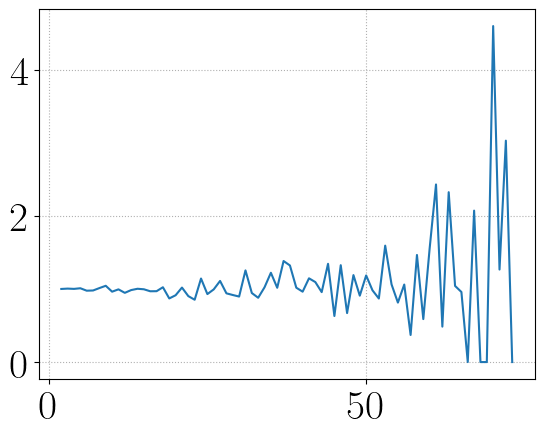

In [337]:
# 3) Conditional (no-previous-flip) p_n with error bars
ns_c, pi_c, err_c = build_prob_arrays(*cond0, min_count=100)
ns_u, pi_u, err_u = build_prob_arrays(*uncond, min_count=100)
plt.figure()
plt.plot(ns_c, pi_c[:pi_u.size]/pi_u[:pi_c.size])
plt.grid(True, which='both', ls=':')
# plt.legend()
plt.show()

In [333]:
pi_c.size,pi_u.size

(55, 83)

# Splitting check

In [174]:
import numpy as np, random, bisect
import matplotlib.pyplot as plt

class MemoryWalk:
    def __init__(self, beta, tau=1.0, max_steps=100000):
        self.beta = beta
        self.tau = tau
        self.max_steps = max_steps
        # Precompute cumulative weights up to max_steps
        lags = np.arange(1, max_steps+1, dtype=np.float64)
        w = (lags + tau) ** (-beta)
        self.cumW = np.cumsum(w)

    def sample_lag_up_to_t(self, t):
        total = self.cumW[t-1]
        r = random.random() * total
        idx = bisect.bisect_left(self.cumW, r)
        return idx + 1

    def simulate_until_absorption(self, n_target, q):
        """
        Run until hitting -1 or +n_target.
        Return True if +n_target hit first, False if -1.
        """
        positions = [0]
        x = 0
        t = 0
        while t<self.max_steps:
            t += 1
            if random.random() < q:
                lag = self.sample_lag_up_to_t(t)
                newpos = positions[t - lag]
            else:
                step = 1 if random.random() < 0.5 else -1
                newpos = x + step

            positions.append(newpos)
            x = newpos

            if x <= -1:
                return False
            if x >= n_target:
                return True
        return None
    
    def cond_pers_n(self, n_target, q):
        # simulate conditioned trajectory to hit n
        # if does not hit n before -1 return -1 (So we know to discard this traj)
        # if hits n but not n+1 before -1 return 0
        # if hits n+1 before -1 return 1
        positions = [0]
        x = 0
        t = 0
        reach_n = 0
        while t<self.max_steps:
            t += 1
            if random.random() < q:
                lag = self.sample_lag_up_to_t(t)
                newpos = positions[t - lag]
            else:
                step = 1 if random.random() < 0.5 else -1
                newpos = x + step

            positions.append(newpos)
            x = newpos

            if (x <= -1) and not reach_n:
                return -1
            if (x <= -1) and reach_n:
                return 0
            if x >= n_target:
                reach_n = 1
            if x>=n_target+1:
                return 1
        return None
    
    def uncond_pers_n(self, n_target, q):
        # flip prob at step n
        positions = [0]
        x = 0
        t = 0
        reach_n = 0
        M = 0
        m = 0
        extrema=[0]
        while t<self.max_steps:
            t += 1
            if random.random() < q:
                lag = self.sample_lag_up_to_t(t)
                newpos = positions[t - lag]
            else:
                step = 1 if random.random() < 0.5 else -1
                newpos = x + step
                if newpos > M:
                    M = newpos
                    extrema.append(M)
                if newpos < m:
                    m = newpos
                    extrema.append(m)
            positions.append(newpos)
            x = newpos
            # print(M-m)
            if M-m == n_target:
                # print('x')
                return ((extrema[-1] * extrema[-2]) < 0)
        return None
    

def estimate_splitting(n_values, q=0.1, beta=1.5, tau=1.0, ntrials=2000):
    walk = MemoryWalk(beta, tau, max_steps=10000000)
    probs, errs = [], []
    for n in n_values:
        wins = 0
        for _ in range(ntrials):
            if walk.simulate_until_absorption(n, q):
                wins += 1
        p = wins / ntrials
        se = np.sqrt(p*(1-p)/ntrials)
        probs.append(p)
        errs.append(se)
    return np.array(probs), np.array(errs)

def estimate_flip(n_values, q=0.1, beta=1.5, tau=1.0, ntrials=2000):
    walk = MemoryWalk(beta, tau, max_steps=1000000)
    probs, errs = [], []
    for n in n_values:
        wins = 0
        for _ in range(ntrials):
            x=walk.uncond_pers_n(n, q)
            wins += x
        p = wins / ntrials
        se = np.sqrt(p*(1-p)/ntrials)
        probs.append(p)
        errs.append(se)
    return np.array(probs), np.array(errs)

def estimate_cond_flip(n_values, q=0.1, beta=1.5, tau=1.0, ntrials=2000):
    walk = MemoryWalk(beta, tau, max_steps=1000000)
    probs, errs = [], []
    for n in n_values:
        wins = 0
        cond =0 
        for _ in range(ntrials):
            x=walk.cond_pers_n(n, q)
            if x != -1:
                cond+=1
                wins += x
        p = 1- wins / cond
        se = np.sqrt(p*(1-p)/cond)
        probs.append(p)
        errs.append(se)
    return np.array(probs), np.array(errs)


[0.05033333 0.04686667 0.04753333 0.04726667 0.0466     0.04593333
 0.047     ]


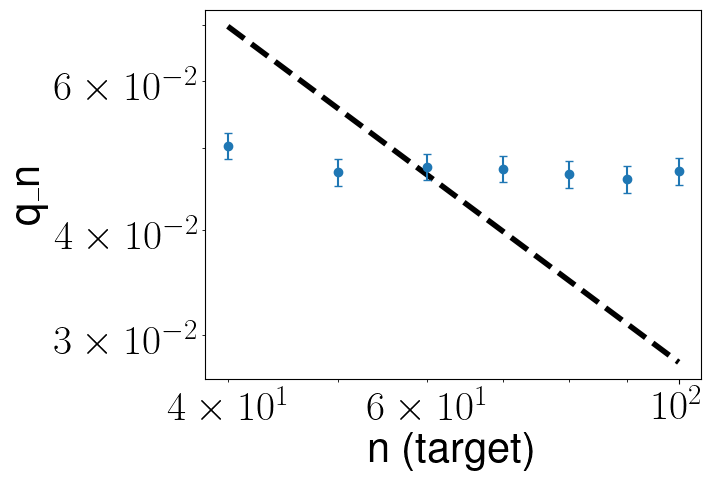

In [ ]:
def flin(x,a,b):
    return -a*x+b

if __name__ == "__main__":
    q = 0.01
    beta = .8
    tau = 1.0
    ntrials = 15000

    n_values = np.arange(40, 110, 10)
    probs_split, errs_split = estimate_flip(n_values, q=q, beta=beta, tau=tau, ntrials=ntrials)
    print(probs_split)
    # phi,A = curve_fit(flin, np.log(n_values), np.log(probs_split), sigma=errs_split)[0]
    A = curve_fit(finv, n_values, probs_split, sigma=errs_split)[0][0]
    # print(phi,A)
    plt.plot(n_values,A/n_values,'--k',linewidth=4)

    plt.errorbar(n_values, probs_split, yerr=errs_split, fmt='o', capsize=3, label="memory walk")
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("n (target)")
    plt.ylabel("pi_n")
    # plt.legend()
    # plt.title(f"Splitting probability, q={q}, beta={beta}")
    plt.show()

In [125]:
print(A)

1.0233888397730697


[0.05777166 0.05128205 0.06224066 0.03170732 0.03012048 0.04067797
 0.02564103 0.02713178 0.03181818 0.03623188 0.03370787 0.02142857
 0.02816901 0.05405405 0.06363636 0.04597701 0.05333333 0.015625
 0.04477612 0.01851852]


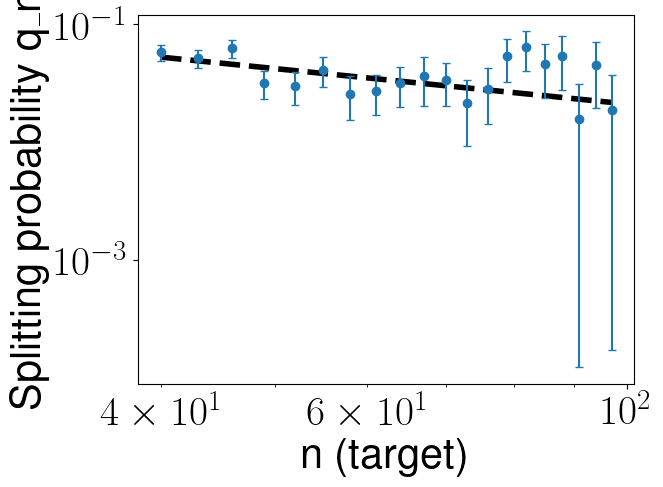

In [ ]:
if __name__ == "__main__":
    q = 0.1
    beta = 1.4
    tau = 1.0
    ntrials = 100000

    n_values = np.arange(40, 100,3)
    probs, errs = estimate_cond_flip(n_values, q=q, beta=beta, tau=tau, ntrials=ntrials)
    print(probs)
    A = curve_fit(finv, n_values,probs, sigma=errs)[0][0]
    plt.plot(n_values,A/n_values,'--k',linewidth=4)

    plt.errorbar(n_values, probs, yerr=errs, fmt='o', capsize=3, label="memory walk")
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("n (target)")
    plt.ylabel("pintilde0")
    # plt.legend()
    # plt.title(f"Splitting probability, q={q}, beta={beta}")
    plt.show()


[0.13013333 0.06026667 0.036      0.02366667 0.01813333 0.01386667
 0.01206667 0.00953333 0.0088     0.00906667 0.00646667 0.0064
 0.00486667 0.00393333 0.00486667 0.00366667 0.00413333 0.00393333
 0.00346667]
1.2606503344698425 0.033998319537437593


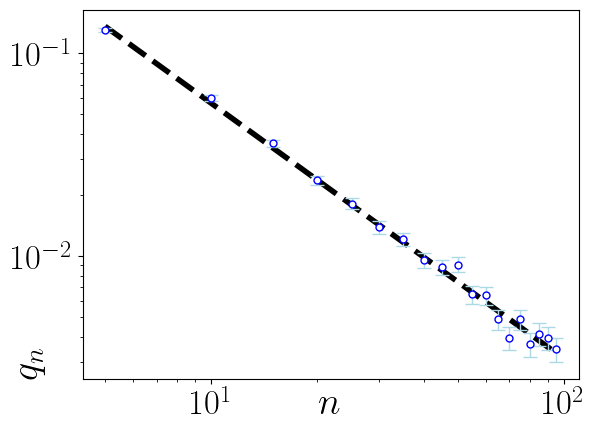

In [177]:
def flin(x,a,b):
    return -a*x+b
fig, ax = plt.subplots(1, 1)

q = 0.3
beta = 2.1
tau = 1.0
ntrials = 15000

n_values = np.arange(5, 100, 5)
probs_split, errs_split = estimate_splitting(n_values, q=q, beta=beta, tau=tau, ntrials=ntrials)
print(probs_split)
phi,A = curve_fit(flin, np.log(n_values), np.log(probs_split), sigma=errs_split)[0]
# A = curve_fit(finv, n_values, probs_split, sigma=errs_split)[0][0]
print(phi,A)
plt.plot(n_values,np.exp(A)/n_values**phi,'--k',linewidth=4)

plt.errorbar(n_values, probs_split, yerr=errs_split, fmt='o', color='blue', ecolor='lightblue', elinewidth=1, capsize=5, markersize=5, markerfacecolor='white', markeredgewidth=1)



plt.semilogx()
plt.semilogy()
plt.ylabel(r'$q_n$',fontsize=28,labelpad=-25,loc='bottom')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='center')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.legend()
# plt.title(f"Splitting probability, q={q}, beta={beta}")
plt.savefig(f'C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/splitting-Monkey-beta{beta}-q{q}.pdf', dpi=600, bbox_inches='tight')

plt.show()

7502296167.708334 7.165516313798323


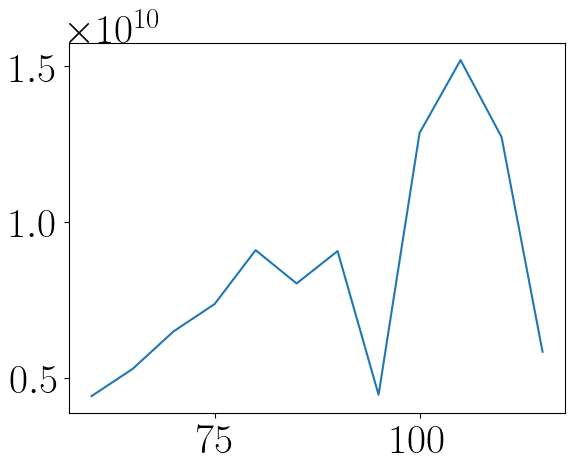

In [143]:
print(np.exp(A),phi)
plt.plot(n_values, probs_split*n_values**phi)

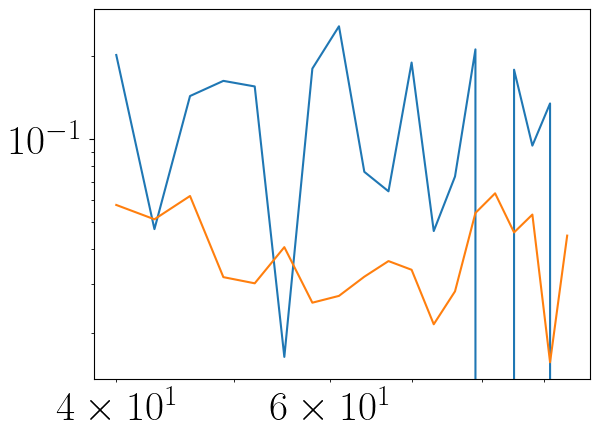

In [ ]:
plt.plot(n_values[:-1],1-(probs_split[1:]/probs_split[:-1]))
plt.loglog(n_values[:-1],probs[:-1])